In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

2025-05-30 09:19:25.639509: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=10000)]  # MB
        )
        print("VRAM limited to 1500 MB.")
    except RuntimeError as e:
        print("Memory configuration must be set at program start:", e)


VRAM limited to 1500 MB.


2025-05-30 09:19:27.360531: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-05-30 09:19:29.762234: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-05-30 09:19:29.762306: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


INPUT PL OUTPUT PO

In [3]:
def load_and_clean_csv(path):
    df = pd.read_csv(path)
    
    # Drop last 6 rows
    df = df.iloc[:-6]
    
    # Convert date column to datetime
    df['#date+time'] = pd.to_datetime(df['#date+time'], errors='coerce')
    df = df.rename(columns={'#date+time': 'date_time'})
    
    # Convert all other columns to numeric
    for col in df.columns:
        if col != 'date_time':
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df
def wind_to_uv(speed, direction_deg):
    # Convert to radians
    direction_rad = np.deg2rad(direction_deg)

    # U = -speed * sin(direction), V = -speed * cos(direction)
    # This converts FROM meteorological TO Cartesian
    u = -speed * np.sin(direction_rad)
    v = -speed * np.cos(direction_rad)
    return u, v

def prepare_dataframe(df):
    # Rename columns to a consistent format
    df = df.rename(columns={
        df.columns[0]: 'date_time',
        df.columns[1]: 'pwl',
        df.columns[2]: 'wsd',
        df.columns[3]: 'wdr'
    })
    
    # Convert wind to U/V components
    u, v = wind_to_uv(df['wsd'], df['wdr'])
    df[['u', 'v']] = np.column_stack((u, v))
    
    # Drop raw wind columns
    df.drop(columns=['wsd', 'wdr'], inplace=True)
    
    return df
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
import numpy as np

def calculate_central_frequency_percentage(y_true, y_pred, threshold_cm):
    """Percentage of predictions within ±threshold_cm of truth"""
    y_true = np.asarray(y_true).flatten()
    y_pred = np.asarray(y_pred).flatten()
    diff = np.abs(y_true - y_pred)
    within_threshold = diff <= (threshold_cm / 100.0)  # convert cm to meters
    return np.mean(within_threshold) * 100  # percent

def evaluate_model(model, X_test, y_test, y_mean=None, y_std=None, config=None, results_df=None):

    print("Evaluating model on test data...")
    loss, mae = model.evaluate(X_test, y_test, batch_size=len(X_test), verbose=0)
    print(f"Raw Loss: {loss:.6f}, Raw MAE: {mae:.6f}")

    # Predict
    y_pred = model.predict(X_test, batch_size=len(X_test), verbose=0)

    y_test_unscaled = y_test
    y_pred_unscaled = y_pred

    # Metrics
    cf_15cm = calculate_central_frequency_percentage(y_test_unscaled, y_pred_unscaled, 15)
    cf_5cm = calculate_central_frequency_percentage(y_test_unscaled, y_pred_unscaled, 5)
    cf_1cm = calculate_central_frequency_percentage(y_test_unscaled, y_pred_unscaled, 1)
    mse = mean_squared_error(y_test_unscaled.flatten(), y_pred_unscaled.flatten())
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_unscaled.flatten(), y_pred_unscaled.flatten())
    medae = median_absolute_error(y_test_unscaled.flatten(), y_pred_unscaled.flatten())
    r2 = r2_score(y_test_unscaled.flatten(), y_pred_unscaled.flatten())

    # Report
    print(f"\n📊 Evaluation Metrics (unscaled to meters):")
    print(f"Central Frequency (±15cm): {cf_15cm:.2f}%")
    print(f"Central Frequency (±5cm):  {cf_5cm:.2f}%")
    print(f"Central Frequency (±1cm):  {cf_1cm:.2f}%")
    print(f"MAE:   {mae:.4f} m")
    print(f"RMSE:  {rmse:.4f} m")
    print(f"MSE:   {mse:.6f}")
    print(f"MedAE: {medae:.4f} m")
    print(f"R²:    {r2:.4f}")
    if config is not None:
        row = {
            'Inputs': config.get('Inputs', X_test.shape[1]),
            'WL HR': config.get('WL_HR', '-'),
            'WIND HR': config.get('WIND_HR', '-'),
            'Layer 1': config.get('Layer_1', '-'),
            'Layer 2': config.get('Layer_2', '-'),
            'Dropout': config.get('Dropout', '-'),
            'Epochs': config.get('Epochs', '-'),
            'Batch Size': config.get('Batch_Size', '-'),
            'R2': r2,
            'CF 1cm': cf_1cm,
            'MAE': mae,
            'RMSE': rmse,
            'MSE': mse
        }

        if results_df is None:
            results_df = pd.DataFrame(columns=row.keys())

        results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)

        return results_df

    return None

file_paths = {
    'po11': '/home/ryan/Downloads/po_2011-2012.csv',
    'pl11': '/home/ryan/Downloads/pl_2011-2012.csv',
    'po13': '/home/ryan/Downloads/po_2013-2014.csv',
    'pl13': '/home/ryan/Downloads/pl_2013-2014.csv',
    'po15': '/home/ryan/Downloads/po_2015-2016.csv',
    'pl15': '/home/ryan/Downloads/pl_2015-2016.csv',
}


In [4]:
datasets = {key: load_and_clean_csv(path) for key, path in file_paths.items()}


/tmp/ipykernel_412063/1169060759.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
/tmp/ipykernel_412063/1169060759.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


In [ ]:

for name, df in datasets.items():
    datasets[name] = prepare_dataframe(df)


"\nfor df in datasets.values():\n    for col in df.columns:\n        if col != 'date_time':\n            df[col] = df[col].interpolate(limit_direction='both')\n\n\n"

In [6]:
for key in ['pl11', 'pl13', 'pl15']:
    df = datasets[key]
    hourly_df = df[df['date_time'].dt.minute == 0].copy()
    datasets[f'{key}_uv_hourly'] = hourly_df.reset_index(drop=True)



only pwl, 1hr before and after point of PWL, and only past winds

In [7]:
'''def   input_output_arrays(pl_df, po_df, wl_half_window=5, wind_window=30, wind_step=10):
    """
    Predict po.pwl[t] using:
    - pl.pwl[t-5:t+6] → 11 values (past, current, future)
    - pl.u, pl.v from t-30 to t (3 hourly steps)
    """
    pl_df = pl_df.reset_index(drop=True)
    po_df = po_df.reset_index(drop=True)

    pl_pwl = pl_df['pwl'].to_numpy()
    pl_u   = pl_df['u'].to_numpy()
    pl_v   = pl_df['v'].to_numpy()
    po_pwl = po_df['pwl'].to_numpy()

    X, y, indices = [], [], []

    for t in range(wind_window, len(pl_df) - wl_half_window):
        # Water level: centered window [t-5 : t+5]
        wl_slice = slice(t - wl_half_window, t + wl_half_window + 1)
        # Wind: hourly up to t
        wind_slice = slice(t - wind_window + 1, t + 1, wind_step)

        pwl_input = pl_pwl[wl_slice]     # 11
        u_input = pl_u[wind_slice]       # 3
        v_input = pl_v[wind_slice]       # 3
        target = po_pwl[t]

        if (
            np.isnan(pwl_input).any() or
            np.isnan(u_input).any() or
            np.isnan(v_input).any() or
            np.isnan(target)
        ):
            continue

        features = np.concatenate([pwl_input, u_input, v_input])
        X.append(features)
        y.append(target)
        indices.append(t)

    return np.array(X), np.array(y), np.array(indices)
'''

'def   input_output_arrays(pl_df, po_df, wl_half_window=5, wind_window=30, wind_step=10):\n    """\n    Predict po.pwl[t] using:\n    - pl.pwl[t-5:t+6] → 11 values (past, current, future)\n    - pl.u, pl.v from t-30 to t (3 hourly steps)\n    """\n    pl_df = pl_df.reset_index(drop=True)\n    po_df = po_df.reset_index(drop=True)\n\n    pl_pwl = pl_df[\'pwl\'].to_numpy()\n    pl_u   = pl_df[\'u\'].to_numpy()\n    pl_v   = pl_df[\'v\'].to_numpy()\n    po_pwl = po_df[\'pwl\'].to_numpy()\n\n    X, y, indices = [], [], []\n\n    for t in range(wind_window, len(pl_df) - wl_half_window):\n        # Water level: centered window [t-5 : t+5]\n        wl_slice = slice(t - wl_half_window, t + wl_half_window + 1)\n        # Wind: hourly up to t\n        wind_slice = slice(t - wind_window + 1, t + 1, wind_step)\n\n        pwl_input = pl_pwl[wl_slice]     # 11\n        u_input = pl_u[wind_slice]       # 3\n        v_input = pl_v[wind_slice]       # 3\n        target = po_pwl[t]\n\n        if (\n     

In [25]:


def input_output_arrays(pl_df, po_df, po_hourly_wind_df, wl_half_window=5, wind_window=3):
    """
    Predict po.pwl[t] using:
    - pl.pwl[t-5:t+6] → 11 values (past, current, future)
    - hourly u/v from po station (po_hourly_wind_df): 3 hourly values ending at time t
    """
    pl_df = pl_df.reset_index(drop=True)
    po_df = po_df.reset_index(drop=True)
    po_hourly_wind_df = po_hourly_wind_df.reset_index(drop=True)

    pl_pwl = pl_df['pwl'].to_numpy()
    po_pwl = po_df['pwl'].to_numpy()

    # Create lookup map from datetime to [u, v] for PO station
    hourly_wind_map = po_hourly_wind_df.set_index('date_time')[['u', 'v']]
    available_wind_times = set(hourly_wind_map.index)

    X, y, indices = [], [], []
    datetimes = pl_df['date_time'].values

    for t in range(wl_half_window, len(pl_df) - wl_half_window):
        curr_time = datetimes[t]

        # Water level input from PL station (centered at t)
        pwl_input = pl_pwl[t - wl_half_window: t + wl_half_window + 1]

        # Wind input from PO station, past 3 hours
        hourly_times = [(curr_time - pd.Timedelta(hours=i)).replace(minute=0, second=0, microsecond=0)
                        for i in reversed(range(wind_window))]

        if not all(ts in available_wind_times for ts in hourly_times):
            continue  # skip if any hourly wind value is missing

        uv_values = np.concatenate([hourly_wind_map.loc[ts].values for ts in hourly_times])
        target = po_pwl[t]

        if np.isnan(pwl_input).any() or np.isnan(uv_values).any() or np.isnan(target):
            continue

        features = np.concatenate([pwl_input, uv_values])
        X.append(features)
        y.append(target)
        indices.append(t)

    return np.array(X), np.array(y), np.array(indices)


In [8]:

_last_wl_hr = None
_last_wind_hr = None

_cached_data = {}

def model_config(l1, dropout, epochs, wl_hr, wind_hr, results_df=None):
    global _last_wl_hr, _last_wind_hr, _cached_data

    wl_half_window = wl_hr * 10  # 6-min steps → 10 per hour
    wind_window = wind_hr        # hourly values, already filtered

    # Only recompute if window sizes changed
    if wl_hr != _last_wl_hr or wind_hr != _last_wind_hr:
        print("⚙️ Recomputing input/output arrays for new WL_HR and WIND_HR settings...")

        _cached_data['X_train'], _cached_data['y_train'], _cached_data['idx_train'] = input_output_arrays(
            datasets['pl11'], datasets['po11'], datasets['pl11_uv_hourly'],
            wl_half_window=wl_half_window, wind_window=wind_window
        )
        _cached_data['X_valid'], _cached_data['y_valid'], _cached_data['idx_valid'] = input_output_arrays(
            datasets['pl13'], datasets['po13'], datasets['pl13_uv_hourly'],
            wl_half_window=wl_half_window, wind_window=wind_window
        )
        _cached_data['X_test'], _cached_data['y_test'], _cached_data['idx_test'] = input_output_arrays(
            datasets['pl15'], datasets['po15'], datasets['pl15_uv_hourly'],
            wl_half_window=wl_half_window, wind_window=wind_window
        )

        _last_wl_hr = wl_hr
        _last_wind_hr = wind_hr

    # Unpack cached data
    X_train = _cached_data['X_train']
    y_train = _cached_data['y_train']
    X_valid = _cached_data['X_valid']
    y_valid = _cached_data['y_valid']
    X_test  = _cached_data['X_test']
    y_test  = _cached_data['y_test']

    model_file_name = 'model2.keras'
    BATCH_SIZE = len(X_train)
    inputs = X_train.shape[1]

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(inputs,)),
        tf.keras.layers.Dense(l1, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(model_file_name, monitor='val_loss', save_best_only=True, mode='min', verbose=1)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=epochs,
        batch_size=BATCH_SIZE,
        validation_batch_size=len(X_valid),
        callbacks=[early_stop, checkpoint]
    )

    config = {
        'Inputs': inputs,
        'WL_HR': wl_hr,
        'WIND_HR': wind_hr,
        'Layer_1': l1,
        'Layer_2': 0,
        'Dropout': dropout,
        'Epochs': epochs,
        'Batch_Size': BATCH_SIZE
    }

    y_mean = np.mean(y_train)
    y_std = np.std(y_train)

    results_df = evaluate_model(
        model, X_test, y_test,
        y_mean=y_mean, y_std=y_std,
        config=config,
        results_df=results_df
    )

    return model, results_df



In [9]:
results_df = pd.DataFrame()

In [65]:
results_df.sort_values(by='R2', ascending=False, inplace=True)
results_df.to_clipboard()

In [29]:
X_train, y_train, idx_train = input_output_arrays(
    datasets['pl11'], datasets['po11'], datasets['pl11_uv_hourly'],
    wl_half_window=30, wind_window=12
)

X_valid, y_valid, idx_valid = input_output_arrays(
    datasets['pl13'], datasets['po13'], datasets['pl13_uv_hourly'],
    wl_half_window=30, wind_window=12
)

X_test, y_test, idx_test = input_output_arrays(
    datasets['pl15'], datasets['po15'], datasets['pl15_uv_hourly'],
    wl_half_window=30, wind_window=12
)

In [45]:
model_file_name = 'model2.6.keras'
BATCH_SIZE = len(X_train)
inputs = X_train.shape[1]

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(inputs,)),
    tf.keras.layers.Dense(170, activation='relu'),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dropout(0.002),
    tf.keras.layers.Dense(1, kernel_initializer='normal')
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint(model_file_name, monitor='val_loss', save_best_only=True, mode='min', verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=1000,
    batch_size=BATCH_SIZE,
    validation_batch_size=len(X_valid),
    callbacks=[early_stop, checkpoint]
)


Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 12.3347 - mae: 3.5038
Epoch 1: val_loss improved from inf to 10.30732, saving model to model2.6.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 12.3347 - mae: 3.5038 - val_loss: 10.3073 - val_mae: 3.2000
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 10.3473 - mae: 3.2072
Epoch 2: val_loss improved from 10.30732 to 8.56034, saving model to model2.6.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 10.3473 - mae: 3.2072 - val_loss: 8.5603 - val_mae: 2.9122
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 8.5585 - mae: 2.9123
Epoch 3: val_loss improved from 8.56034 to 6.99557, saving model to model2.6.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 8.5585 - mae: 2.9123 - val_loss: 6.9956 - val_mae: 2.6256
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 6.9544 - mae: 2.6174
Epoch 4: val_loss improved from 6.99557 to 5.59337, saving model to model2.6.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/s

In [46]:
def evaluate_model2(model, testing_input_array, testing_label_array):
  from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, mean_absolute_percentage_error
  """Calculates loss, makes predictions, and calculates Central Frequency (CF),
  Mean Squared Error (MSE), Root Mean Squared Error(RMSE), Mean Absolute Error (MAE),
  Median Absolute Error, and R-squared (R2)

	Args:
        model (tf.keras.model): The trained model

        testing_input_array (array): Testing inputs

        testing_label_array (array): Testing labels
	"""
  print("Calculating Loss:")
  test_loss = model.evaluate(testing_input_array, testing_label_array, batch_size = len(testing_input_array))

  print("Loss:", test_loss)


  print("\nGenerating output predictions with model:")
  predictions = model.predict(testing_input_array, batch_size = len(testing_input_array))

  # Calculate evaluation metrics
  cf_15cm_percentage = calculate_central_frequency_percentage(testing_label_array, predictions, 15)
  cf_5cm_percentage = calculate_central_frequency_percentage(testing_label_array, predictions, 5)
  cf_1cm_percentage = calculate_central_frequency_percentage(testing_label_array, predictions, 1)
  mse = mean_squared_error(testing_label_array, predictions)
  rmse = root_mean_squared_error(testing_label_array, predictions)
  mae = mean_absolute_error(testing_label_array, predictions)
  medae = median_absolute_error(testing_label_array, predictions)
  r2 = r2_score(testing_label_array, predictions)

  print("\nCentral Frequency Percentage 15cm:", cf_15cm_percentage)
  print("\nCentral Frequency Percentage 5cm:", cf_5cm_percentage)
  print("\nCentral Frequency Percentage 1cm:", cf_1cm_percentage)
  print("Mean Squared Error:", mse)
  print("Root Mean Squared Error:", rmse)
  print("Mean Absolute Error:", mae)
  print("Median Absolute Error:", medae)
  print("R-squared:", r2)


In [47]:
evaluate_model2(model,X_test, y_test)

Calculating Loss:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step - loss: 0.0084 - mae: 0.0532
Loss: [0.008368647657334805, 0.053248047828674316]

Generating output predictions with model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step

Central Frequency Percentage 15cm: 95.49753484403148

Central Frequency Percentage 5cm: 62.709775291552106

Central Frequency Percentage 1cm: 14.736417938750357
Mean Squared Error: 0.008368648938165997
Root Mean Squared Error: 0.09148031995006356
Mean Absolute Error: 0.05324805238532424
Median Absolute Error: 0.03687351036071762
R-squared: 0.7342754075465058


In [48]:
y_pred = model.predict(X_test, batch_size=len(X_test)).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


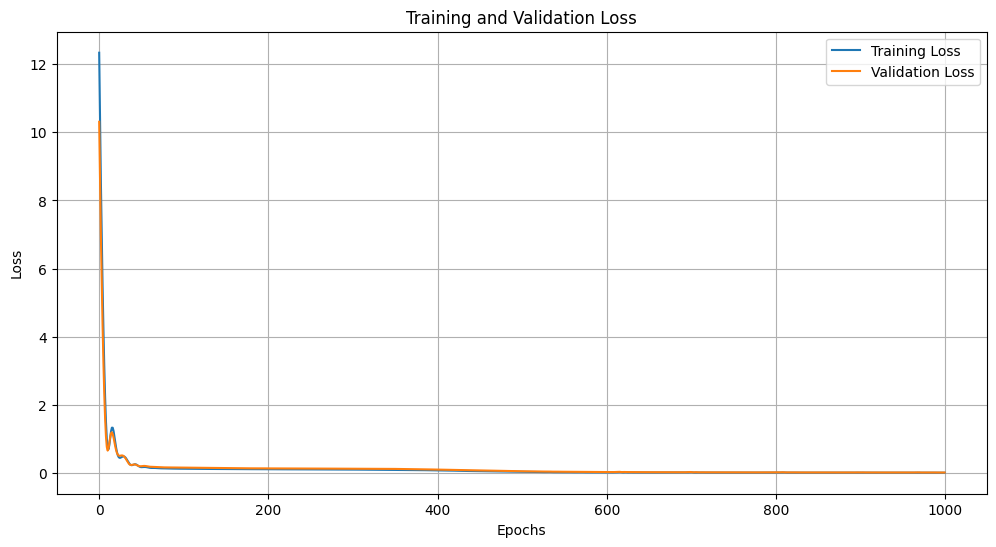

In [49]:
#plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

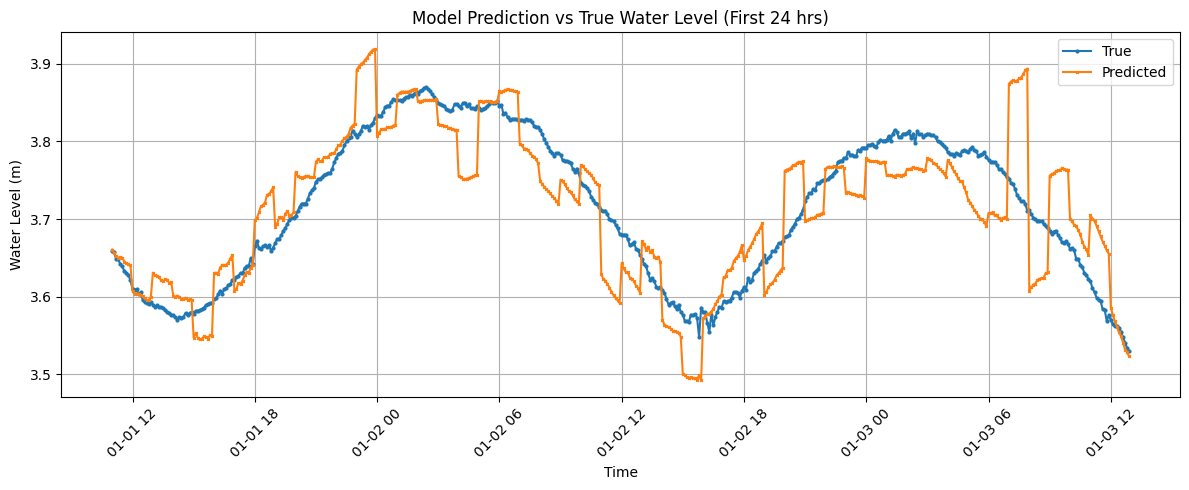

In [50]:
timestamps = datasets['po15']['date_time'].iloc[idx_test].reset_index(drop=True)


plot_range = 500

plt.figure(figsize=(12, 5))
plt.plot(timestamps[:plot_range], y_test[:plot_range], label='True', marker='o', markersize=2)
plt.plot(timestamps[:plot_range], y_pred[:plot_range], label='Predicted', marker='x', markersize=2)
plt.xlabel("Time")
plt.ylabel("Water Level (m)")
plt.title("Model Prediction vs True Water Level (First 24 hrs)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
